# pyWavelet snow radar retrieval demonstrator
Wavelet-based approach to retrieve snow depth from the CRESIS snow radar. The code is ported from the original MATLAB work of Thomas Newman.

Dependencies: numpy, scipy, pywavelet, matplotlib

&copy; J.King 2018

Original work &copy; T.Newman 2015

In [1]:
import os
import numpy as np
import scipy.io as spio
from scipy import signal
from scipy.signal import find_peaks_cwt
import matplotlib.pyplot as plt
import pywt

### Load the CRESIS mat file
The code currently uses the mat files from the CRESIS ftp but should be updaded to use the nc version from NSIDC. Borrowed the MATLAB reader from here:
https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [2]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

Load the Snow Radar mat file

In [3]:
radar_file = "./data/sr/Data_20160419_04_010.mat"
radar_dat =  loadmat(radar_file)

### Processing constants

Assign assumed snow density, define signal overampling, and gather signal properties

In [4]:
density_snow = 0.32 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1+0.51*density_snow)**3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

oversample_num = 1000
num_nyquist_ts = 100 #number of nyquist timesteps

bandwidth = np.abs((radar_dat['param_records']['radar']['wfs']['f1']-radar_dat['param_records']['radar']['wfs']['f0'])*radar_dat['param_records']['radar']['wfs']['fmult'])
delta_fast_time = radar_dat['Time'][1] - radar_dat['Time'][0] 
delta_fast_time_range = (delta_fast_time/2)*c

## Calculates the pulsewidth
Calulate the equivalent pulseidth and null to null pulsewidth in space given an input bandwidth and window function
Ported from calculatePulseWidth.m

In [5]:
nyquist_sf = 2*bandwidth #nyquist sampling frequency
fs = nyquist_sf *oversample_num #sampling frequency
time_step = 1/fs # The sample spacing in time
max_time  = num_nyquist_ts*oversample_num*time_step
time_vect = np.arange(-max_time,max_time,time_step)

In [6]:
half_bandwidth = bandwidth/2
n_FFT= len(time_vect)
f = fs*np.linspace(-0.5,0.5,n_FFT)
n_band_points = np.sum(np.abs(f)<=half_bandwidth)
spectral_win = signal.hann(n_band_points)

In [7]:
freq_domain_signal = np.zeros(len(f))
freq_domain_signal[np.abs(f)<half_bandwidth] = spectral_win
shift_freq_domain_signal = np.fft.ifftshift(freq_domain_signal)
time_domain_signal = np.fft.ifft(shift_freq_domain_signal)*n_FFT
time_sig = np.fft.fftshift(time_domain_signal)
power_signal = np.abs(time_sig**2)
power_signal_norm = power_signal/np.max(power_signal)

In [8]:
max_val = np.max(power_signal_norm)
max_idx = np.argmax(power_signal_norm)

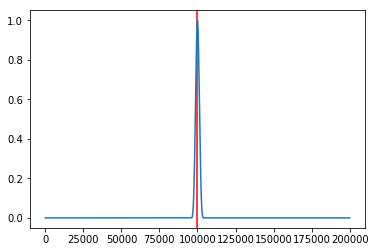

In [9]:
fig, ax = plt.subplots()
ax.plot(power_signal_norm)
ax.vlines(max_idx, 0, 1, transform=ax.get_xaxis_transform(), colors='r')
plt.show()

In [10]:
equiv_pulse_width_val = np.sum(power_signal_norm)
equiv_pulse_width_time = equiv_pulse_width_val*time_step
equiv_pulse_width = equiv_pulse_width_time*c

The peak detection is not exactly the same as MATLAB but it works well enough. Div 0 errors on log10 can be safely ignored.

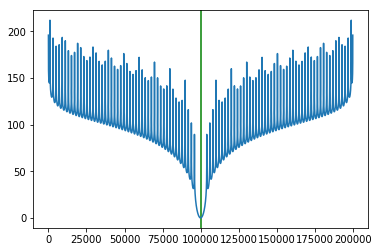

In [11]:
with np.errstate(divide="ignore"):
    invert_l10_power = -10 * np.log10(power_signal_norm)
peak_idx, _ = signal.find_peaks(invert_l10_power)
closest_peaks = np.sort(np.abs(peak_idx - max_idx))

fig, ax = plt.subplots()
ax.plot(invert_l10_power)
ax.vlines(max_idx, 0, 1, transform=ax.get_xaxis_transform(), colors='g')
plt.show()

In [12]:
null_2_width = 2 * np.mean(closest_peaks[0:1])
null_2_time = null_2_width * time_step
null_2_space = null_2_time * c

### Pick Air-Snow and Snow-Ice interfaces

In [13]:
ref_scale_lin_m = 2 * null_2_space
max_scale_lin = np.ceil(ref_scale_lin_m / delta_fast_time_range)
lin_scale_vect_pre = np.arange(2, max_scale_lin, 1)
lin_scale_vect = lin_scale_vect_pre[np.mod(lin_scale_vect_pre, 2) == 1]

In [14]:
ref_snow_layer = 1
snow_layer_opl = ref_snow_layer * n_snow * 2
ref_scale_log_m = 2 * snow_layer_opl
max_scale_log = np.ceil(ref_scale_log_m / delta_fast_time_range)
log_scale_vect_pre = np.arange(2, max_scale_log, 1)
log_scale_vect = log_scale_vect_pre[np.mod(log_scale_vect_pre, 2) == 1]

In [15]:
data_col = radar_dat['Data'][:,0]

I'm using the db1 wavelet which is equivelent to haar. There is no method in python for the old MATLABCWT so I've hacked this together from pywt's CWT methods. They don't allow discrete wavelets to be used so I've had to change it around a bit to accomodate this. 

In [16]:
wavelet = pywt.Wavelet('db1')
data = data_col
scales = lin_scale_vect
lin_coefs = np.zeros((np.size(scales), data.size))

In [17]:
for i in np.arange(np.size(scales)):
    precision = 10
    int_psi, x = pywt.integrate_wavelet(wavelet, precision=precision)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scales[i] * (x[-1] - x[0]) + 1) / (scales[i] * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
    coef = -np.sqrt(scales[i]) * np.diff(
        np.convolve(data, int_psi[j.astype(np.int)][::-1]))
    d = (coef.size - data.size) / 2.
    lin_coefs[i, :] = coef[int(np.floor(d)):int(-np.ceil(d))]

In [18]:
sampling_period = 1
frequencies = pywt.scale2frequency(wavelet, scales, precision)
if np.isscalar(frequencies):
    frequencies = np.array([frequencies])
# MB: possible to one-line this? --> frequencies /= sampling_period
for i in np.arange(len(frequencies)):
    frequencies[i] /= sampling_period

#### TODO: Filter edge cases

In [19]:
sum_lin_coefs = np.sum(lin_coefs, axis=0) / lin_coefs.shape[0]
pks_si = np.max(-sum_lin_coefs)
locs_si = np.argmax(-sum_lin_coefs)

Pick the Air-Snow interface

In [20]:
data_col_log = 10 * np.log10(data_col)
data = data_col_log
scales = log_scale_vect
log_coefs = np.zeros((np.size(scales), data.size))

In [21]:
for i in np.arange(np.size(scales)):
    precision = 10
    int_psi, x = pywt.integrate_wavelet(wavelet, precision=precision)
    step = x[1] - x[0]
    j = np.floor(
        np.arange(scales[i] * (x[-1] - x[0]) + 1) / (scales[i] * step))
    if np.max(j) >= np.size(int_psi):
        j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
    coef = - np.sqrt(scales[i]) * np.diff(
        np.convolve(data, int_psi[j.astype(np.int)][::-1]))
    d = (coef.size - data.size) / 2.
    log_coefs[i, :] = coef[int(np.floor(d)):int(-np.ceil(d))]

In [22]:
sum_log_coefs = np.sum(log_coefs, axis=0) / log_coefs.shape[0]
pks_as = np.max(-sum_log_coefs)
locs_as = np.argmax(-sum_log_coefs)

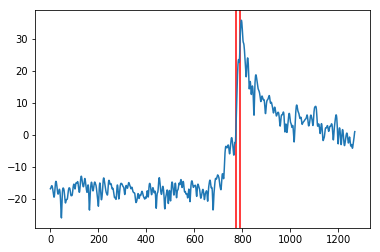

In [23]:
fig, ax = plt.subplots()
ax.plot(data_col_log)
ax.vlines([locs_as, locs_si], 0, 1, transform=ax.get_xaxis_transform(), colors='r')
plt.show()

In [24]:
snowDepth = (locs_si - locs_as) * delta_fast_time_range / n_snow
print(snowDepth) #in m

0.17583319118126367


In [25]:
print(locs_si)
print(locs_as)

791
774
